In [1]:
# Initialize OK
from client.api.notebook import Notebook
ok = Notebook('lab14.ok')

Assignment: lab14
OK, version v1.13.11



# Lab 14: SQL and Decision Trees / Random Forests

This lab will have two fairly short but disjoint parts.

In the first half of this lab, we are going to practice viewing, sorting, grouping, and merging tables with SQL. We will explore the money donated during the 2016 election using the [Federal Election Commission's public records](http://www.fec.gov/finance/disclosure/ftpdet.shtml). You will be connecting to a sqlite database containing the data. The data we will be working with in this lab is quite small (16MB); however, it's taken from a larger database that more is than few GBs.

In the second half of the lab, we will have you train a multi-class classifier with three different models (one-vs-rest logistic regression, decision tree, random forest) and compare the accuracies and decision boundaries created by each.

### Due Date

This assignment is due at **Monday, December 2nd** at 11:59 pm.

### Collaboration Policy

Data science is a collaborative activity. While you may talk with others about this assignment, we ask that you **write your solutions individually**. If you discuss the assignment with others, please **include their names** in the cell below.

**Collaborators:** *list names here*

In [2]:
import pandas as pd

# Part 1 specific
import sqlalchemy
from ds100_utils import fetch_and_cache
from pathlib import Path

# Part 2 specific
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.colors import ListedColormap
import seaborn as sns
import graphviz

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import tree
# ignore the warning you might get from importing ensemble from sklearn
from sklearn import ensemble

/srv/conda/envs/data100/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# Part I – SQL

### Connecting to SQLite

Download the database to local disk drive; this will take about a minute.

In [3]:
db_url = 'https://s3.amazonaws.com/berkeley-ds100/fec_nyc.sqlite'
db_filename = 'fec_nyc.db'
data_dir = Path('data')
fetch_and_cache(db_url, db_filename, data_dir=data_dir)
db_path = data_dir / db_filename

Using cached version that was downloaded (UTC): Sun Nov 24 14:49:40 2019


The following cell will connect to the above database using the SQL Alchemy library. This library is more general than the `sqlite3` module from the standard library because it can connect to several different database management systems, such as MySQL and PostgreSQL. It also supports an advanced feature for generating queries called an [object relational mapper](https://docs.sqlalchemy.org/en/latest/orm/tutorial.html) or ORM, which we won't discuss in this course but is quite useful for application development.

In [4]:
engine = sqlalchemy.create_engine(f"sqlite:///{db_path}")
connection = engine.connect()

To check that everything is working we will list the available tables.

In [5]:
engine.table_names()

['cand', 'comm', 'indiv_sample_nyc']

## Table Descriptions

Here is a list of the tables in the database.  Each table links to the documentation on the [FEC page](http://www.fec.gov/finance/disclosure/ftpdet.shtml) for the dataset.

If you'd like, you can consult the FEC page for the descriptions of the tables to find out what the correspondence is.

- [`cand`](http://www.fec.gov/finance/disclosure/metadata/DataDictionaryCandidateMaster.shtml): Candidates table. Contains names and party affiliation.
- [`comm`](http://www.fec.gov/finance/disclosure/metadata/DataDictionaryCommitteeMaster.shtml): Committees table. Contains committee names and types.
- [`indiv_sample_nyc`](http://www.fec.gov/finance/disclosure/metadata/DataDictionaryContributionsbyIndividuals.shtml): All individual contributions from New York City.

We can see the schemas of these tables with the following code from lecture 24.

In [6]:
for exp in connection.execute('SELECT sql FROM sqlite_master;'):
    print(exp[0])

CREATE TABLE "cand" (
    cand_id character varying(9),
    cand_name text,
    cand_pty_affiliation character varying(3),
    cand_election_yr integer,
    cand_office_st character varying(2),
    cand_office character(1),
    cand_office_district integer,
    cand_ici character(1),
    cand_status character(1),
    cand_pcc character varying(9),
    cand_st1 text,
    cand_st2 text,
    cand_city text,
    cand_st character varying(2),
    cand_zip character varying(10)
)
CREATE TABLE "comm"(
  "cmte_id" TEXT,
  "cmte_nm" TEXT,
  "tres_nm" TEXT,
  "cmte_st1" TEXT,
  "cmte_st2" TEXT,
  "cmte_city" TEXT,
  "cmte_st" TEXT,
  "cmte_zip" TEXT,
  "cmte_dsgn" TEXT,
  "cmte_tp" TEXT,
  "cmte_pty_affiliation" TEXT,
  "cmte_filing_freq" TEXT,
  "org_tp" TEXT,
  "connected_org_nm" TEXT,
  "cand_id" TEXT
)
CREATE TABLE indiv_sample_nyc (
    cmte_id character varying(9),
    amndt_ind character(1),
    rpt_tp character varying(3),
    transaction_pgi character(5),
    image_num bigint,
    trans

We can also look at the tables themselves.

The individual donations made by NY residents are shown below.

In [7]:
# We use `LIMIT 5` to avoid loading a huge table.
# Although our tables shouldn't get too large to display,
# this is generally good practice when working in the
# notebook environment.  Jupyter notebooks don't handle
# very large outputs well. 
query = """
SELECT * from indiv_sample_nyc LIMIT 5
"""
pd.read_sql(query, engine)

,cmte_id,amndt_ind,rpt_tp,transaction_pgi,image_num,transaction_tp,entity_tp,name,city,state,...,employer,occupation,transaction_dt,transaction_amt,other_id,tran_id,file_num,memo_cd,memo_text,sub_id
0,C00445015,N,Q1,P,15951128130,15,IND,"SINGER, TRIPP MR.",NEW YORK,NY,...,"ATLANTIC MAILBOXES, INC.",OWNER,01302015,1000,,A-CF13736,1002485,,,4041420151241812398
1,C00510461,N,Q1,P,15951129284,15E,IND,"SIMON, DANIEL A",NEW YORK,NY,...,N/A,RETIRED,03292015,400,C00401224,VN8JBDDJBA8,1002590,,* EARMARKED CONTRIBUTION: SEE BELOW,4041420151241813640
2,C00422410,N,Q1,P,15970352211,15,IND,"ABDUL RAUF, FEISAL",NEW YORK,NY,...,THE CORDOBA INITIATIVE,CHAIRMAN,03042015,250,,VN8A3DBSYG6,1003643,,,4041620151241914560
3,C00510461,N,Q1,P,15951129280,15,IND,"SCHWARZER, FRANK",NEW YORK,NY,...,METRO HYDRAULIC JACK CO,SALES,01162015,100,,VN8JBDAP4C4,1002590,,* EARMARKED CONTRIBUTION: SEE BELOW,4041420151241813630
4,C00510461,N,Q1,P,15951129281,15,IND,"SCHWARZER, FRANK",NEW YORK,NY,...,METRO HYDRAULIC JACK CO,SALES,02162015,100,,VN8JBDBRDG3,1002590,,* EARMARKED CONTRIBUTION: SEE BELOW,4041420151241813632


Similarly, the database of candidates is given below.

In [8]:
query = '''
SELECT *
FROM cand
LIMIT 5
'''
pd.read_sql(query,engine)

,cand_id,cand_name,cand_pty_affiliation,cand_election_yr,cand_office_st,cand_office,cand_office_district,cand_ici,cand_status,cand_pcc,cand_st1,cand_st2,cand_city,cand_st,cand_zip
0,H0AK00097,"COX, JOHN R.",REP,2014,AK,H,0,C,N,C00525261,P.O. BOX 1092,,ANCHOR POINT,AK,99556
1,H0AL02087,"ROBY, MARTHA",REP,2016,AL,H,2,I,C,C00462143,PO BOX 195,,MONTGOMERY,AL,36101
2,H0AL02095,"JOHN, ROBERT E JR",IND,2016,AL,H,2,C,N,,1465 W OVERBROOK RD,,MILLBROOK,AL,36054
3,H0AL05049,"CRAMER, ROBERT E ""BUD"" JR",DEM,2008,AL,H,5,,P,C00239038,PO BOX 2621,,HUNTSVILLE,AL,35804
4,H0AL05163,"BROOKS, MO",REP,2016,AL,H,5,I,C,C00464149,7610 FOXFIRE DRIVE,,HUNTSVILLE,AL,35802


And lastly, the table of committees is given below.

In [9]:
query = '''
SELECT *
FROM comm
LIMIT 5
'''
pd.read_sql(query,engine)

,cmte_id,cmte_nm,tres_nm,cmte_st1,cmte_st2,cmte_city,cmte_st,cmte_zip,cmte_dsgn,cmte_tp,cmte_pty_affiliation,cmte_filing_freq,org_tp,connected_org_nm,cand_id
0,C00000059,HALLMARK CARDS PAC,ERIN BROWER,2501 MCGEE,MD#288,KANSAS CITY,MO,64108,U,Q,UNK,M,C,,
1,C00000422,AMERICAN MEDICAL ASSOCIATION POLITICAL ACTION ...,"WALKER, KEVIN","25 MASSACHUSETTS AVE, NW",SUITE 600,WASHINGTON,DC,20001,B,Q,,M,M,AMERICAN MEDICAL ASSOCIATION,
2,C00000489,D R I V E POLITICAL FUND CHAPTER 886,TOM RITTER,3528 W RENO,,OKLAHOMA CITY,OK,73107,U,N,,Q,L,TEAMSTERS LOCAL UNION 886,
3,C00000547,KANSAS MEDICAL SOCIETY POLITICAL ACTION COMMITTEE,"C. RICHARD BONEBRAKE, M.D.",623 SW 10TH AVE,,TOPEKA,KS,66612,U,Q,UNK,Q,T,,
4,C00000638,INDIANA STATE MEDICAL ASSOCIATION POLITICAL AC...,"VIDYA KORA, M.D.","322 CANAL WALK, CANAL LEVEL",,INDIANAPOLIS,IN,46202,U,Q,,Q,M,,


In CS61A or CS88, we saw basic queries similar to what we see below, which gives only the id and name of candidates from the Democratic party.

In [10]:
query = '''
SELECT cand_id, cand_name
FROM cand
WHERE cand_pty_affiliation = 'DEM'
LIMIT 5
'''
pd.read_sql(query,engine)

,cand_id,cand_name
0,H0AL05049,"CRAMER, ROBERT E ""BUD"" JR"
1,H0AL07086,"SEWELL, TERRYCINA ANDREA"
2,H0AL07094,"HILLIARD, EARL FREDERICK JR"
3,H0AR01091,"GREGORY, JAMES CHRISTOPHER"
4,H0AR01109,"CAUSEY, CHAD"


---
## Question 1

For this question we will use SQL to extract data out of the `indiv_sample_nyc` table. The schema for this table is given below.

In [11]:
for exp in connection.execute('SELECT sql FROM sqlite_master WHERE name="indiv_sample_nyc";'):
    print(exp[0])

CREATE TABLE indiv_sample_nyc (
    cmte_id character varying(9),
    amndt_ind character(1),
    rpt_tp character varying(3),
    transaction_pgi character(5),
    image_num bigint,
    transaction_tp character varying(3),
    entity_tp character varying(3),
    name text,
    city text,
    state character(2),
    zip_code character varying(12),
    employer text,
    occupation text,
    transaction_dt character varying(9),
    transaction_amt integer,
    other_id text,
    tran_id text,
    file_num bigint,
    memo_cd text,
    memo_text text,
    sub_id bigint
)


### Question 1a

Let's start by looking at 2016 election contributions made by Donald Trump, who was a NY resident during that year. Write a SQL statement that will return the cmte_id, transaction_amt, and name for every contribution made by any donor with "DONALD" and "TRUMP" in their name.


Hint: You'll need to use `WHERE name LIKE '%TRUMP%' AND name LIKE '%DONALD%'`.

<!--
BEGIN QUESTION
name: q1a
-->

In [12]:
query_q1a='''
SELECT
    cmte_id,
    transaction_amt,
    name
FROM indiv_sample_nyc
WHERE name LIKE '%TRUMP%' AND name LIKE '%DONALD%'
'''


res_q1a = pd.read_sql(query_q1a, engine)
res_q1a

,cmte_id,transaction_amt,name
0,C00230482,2600,"DONALD, TRUMP"
1,C00230482,2600,"DONALD, TRUMP"
2,C00014498,9000,"TRUMP, DONALD"
3,C00494229,2000,"TRUMP, DONALD MR"
4,C00571869,2700,"TRUMP, DONALD J."
...,...,...,...
152,C00608489,5,DONALD J TRUMP FOR PRESIDENT INC
153,C00608489,5,DONALD J TRUMP FOR PRESIDENT INC
154,C00608489,5,DONALD J TRUMP FOR PRESIDENT INC
155,C00608489,5,DONALD J TRUMP FOR PRESIDENT INC


In [13]:
ok.grade("q1a");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



### Question 1b

If we look at the list above, it appears that some donations were not by Donald Trump himself, but instead by an entity called "DONALD J TRUMP FOR PRESIDENT INC". If we look at the list of donors, we see that our query only seems to have picked up one such anomalous name.

In [14]:
res_q1a['name'].value_counts()

TRUMP, DONALD J.                    133
DONALD J TRUMP FOR PRESIDENT INC     15
TRUMP, DONALD                         4
DONALD, TRUMP                         2
TRUMP, DONALD J MR.                   1
TRUMP, DONALD MR                      1
TRUMP, DONALD J MR                    1
Name: name, dtype: int64

Revise your query from above so that the 15 donations made by "DONALD J TRUMP FOR PRESIDENT INC" do not appear. Your resulting table should have 142 rows. 

Hint: Consider using `NOT LIKE`

<!--
BEGIN QUESTION
name: q1b
-->

In [15]:
query_q1b = '''
SELECT
    cmte_id,
    transaction_amt,
    name
FROM indiv_sample_nyc
WHERE name LIKE '%TRUMP%' AND name LIKE '%DONALD%' AND name NOT LIKE '%INC%'
'''

res_q1b = pd.read_sql(query_q1b, engine)
res_q1b

,cmte_id,transaction_amt,name
0,C00230482,2600,"DONALD, TRUMP"
1,C00230482,2600,"DONALD, TRUMP"
2,C00014498,9000,"TRUMP, DONALD"
3,C00494229,2000,"TRUMP, DONALD MR"
4,C00571869,2700,"TRUMP, DONALD J."
...,...,...,...
137,C00580100,9752,"TRUMP, DONALD J."
138,C00580100,2574,"TRUMP, DONALD J."
139,C00580100,23775,"TRUMP, DONALD J."
140,C00580100,2000000,"TRUMP, DONALD J."


In [16]:
ok.grade("q1b");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



### Question 1c

As a review of some of the key ideas from CS61A/CS88, let's refine our query above.

We see that many of the contributions above were to the same committee. Create a new SQL query that returns the total amount that Donald Trump contributed to each committee. Your table should have three columns `cmte_id`, `total_amount`, and `num_donations`, where `total_amount` is the total amount contributed to that committee, and `num_donations` is the total number of donations. Your table should be sorted in decreased order of `total_amount`.

Hint: Use `GROUP BY` as covered in CS61A and CS88.

Hint: Use `COUNT(*)` as covered in CS61A and CS88.

Hint: Use `SUM()` as covered in CS61A and CS88.

Hint: Use `ORDER BY` as covered in CS61A and CS88.

Hint: Use `DESC` as covered in CS61A and CS88.

Hint: Your `WHERE` clause should be the same as question 1b.

<!--
BEGIN QUESTION
name: q1c
-->

In [17]:
query_q1c = '''
SELECT
    cmte_id,
    SUM(transaction_amt) AS total_amount,
    COUNT(*) AS num_donations
FROM indiv_sample_nyc
WHERE name LIKE '%TRUMP%' AND name LIKE '%DONALD%' AND name NOT LIKE '%INC%'
GROUP BY cmte_id
ORDER BY total_amount DESC
'''


res_q1c = pd.read_sql(query_q1c, engine)
res_q1c

,cmte_id,total_amount,num_donations
0,C00580100,18633157,131
1,C00055582,10000,1
2,C00014498,9000,1
3,C00571869,5400,2
4,C00230482,5200,2
5,C00034033,5000,1
6,C00136457,5000,1
7,C00554949,2600,1
8,C00494229,2000,1
9,C00369033,1000,1


In [18]:
ok.grade("q1c");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



### Question 1d

Now we'd like to know the name of each committee, i.e. we want to know the name of the identity that Donald Trump was making contributions. Modify your query from question 1c so that it also shows the name of each committee. That is, your table should have four columns `cmte_id`, `total_amount`, `num_donations`, and `cmte_nm`.

The names of the committees are given in the `cmte_nm` column of the `comm` table.

Hint: You'll need to join the `indiv_sample_nyc` and `comm` tables.

Hint: One approach is a nested select statement (a.k.a. subquery) as discussed in lecture.

<!--
BEGIN QUESTION
name: q1d
-->

In [19]:
query_q1d = '''
SELECT
    comm.cmte_id,
    cmte_nm,
    SUM(transaction_amt) AS total_amount,
    COUNT(*) AS num_donations
FROM comm JOIN indiv_sample_nyc
ON indiv_sample_nyc.cmte_id = comm.cmte_id
WHERE name LIKE '%TRUMP%' AND name LIKE '%DONALD%' AND name NOT LIKE '%INC%'
GROUP BY comm.cmte_id
ORDER BY total_amount DESC
'''

res_q1d = pd.read_sql(query_q1d, engine)
res_q1d

,cmte_id,cmte_nm,total_amount,num_donations
0,C00580100,"DONALD J. TRUMP FOR PRESIDENT, INC.",18633157,131
1,C00055582,NY REPUBLICAN FEDERAL CAMPAIGN COMMITTEE,10000,1
2,C00014498,REPUBLICAN PARTY OF IOWA,9000,1
3,C00571869,DONOVAN FOR CONGRESS,5400,2
4,C00230482,GRASSLEY COMMITTEE INC,5200,2
5,C00034033,SOUTH CAROLINA REPUBLICAN PARTY,5000,1
6,C00136457,NEW HAMPSHIRE REPUBLICAN STATE COMMITTEE,5000,1
7,C00554949,FRIENDS OF DAVE BRAT INC.,2600,1
8,C00494229,HELLER FOR SENATE,2000,1
9,C00369033,TEXANS FOR SENATOR JOHN CORNYN INC,1000,1


In [20]:
ok.grade("q1d");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 4
    Failed: 0
[ooooooooook] 100.0% passed



# Part II – Classification

Let's switch gears to classification. We'll now be looking at a dataset of per-game stats for all NBA players in the 2018-19 season. This dataset comes from basketball-reference.com.

In [21]:
nba_data = pd.read_csv("nba18-19.csv")
nba_data.head(5)

,Rk,Player,Pos,Age,Tm,G,GS,MP,FG,FGA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PTS
0,1,Álex Abrines\abrinal01,SG,25,OKC,31,2,19.0,1.8,5.1,...,0.923,0.2,1.4,1.5,0.6,0.5,0.2,0.5,1.7,5.3
1,2,Quincy Acy\acyqu01,PF,28,PHO,10,0,12.3,0.4,1.8,...,0.700,0.3,2.2,2.5,0.8,0.1,0.4,0.4,2.4,1.7
2,3,Jaylen Adams\adamsja01,PG,22,ATL,34,1,12.6,1.1,3.2,...,0.778,0.3,1.4,1.8,1.9,0.4,0.1,0.8,1.3,3.2
3,4,Steven Adams\adamsst01,C,25,OKC,80,80,33.4,6.0,10.1,...,0.500,4.9,4.6,9.5,1.6,1.5,1.0,1.7,2.6,13.9
4,5,Bam Adebayo\adebaba01,C,21,MIA,82,28,23.3,3.4,5.9,...,0.735,2.0,5.3,7.3,2.2,0.9,0.8,1.5,2.5,8.9


Our goal will be to predict a player's position given several other features. The 5 positions in basketball are PG, SG, SF, PF, and C (which stand for point guard, shooting guard, small forward, power forward, and center). This information is contained in the `Pos` column.

In [22]:
nba_data['Pos'].value_counts()

SG       176
PF       147
PG       139
C        120
SF       118
SF-SG      2
PF-SF      2
SG-PF      1
PF-C       1
SG-SF      1
C-PF       1
Name: Pos, dtype: int64

While we could set out to try and perform 5-class classification, the results (and visualizations) are slightly more interesting if we try and categorize players into 1 of 3 categories: **guard**, **forward**, and **center**. The below code will take the `Pos` column of our dataframe and use it to create `Pos3`.

In [23]:
def basic_position(pos):
    if 'F' in pos:
        return 'F'
    elif 'G' in pos:
        return 'G'
    return 'C'

nba_data['Pos3'] = nba_data['Pos'].apply(basic_position)
nba_data['Pos3'].value_counts()

G    315
F    273
C    120
Name: Pos3, dtype: int64

Furthermore, since there are **many** players in the NBA (in the 2018-19 season there were 530 unique players), our visualizations can tend to get noisy and messy. Let's restrict our data to only contain rows for players that averaged 10 or more points per game.

In [24]:
nba_data = nba_data[nba_data['PTS'] > 10]

Now, let's look at a scatterplot of Rebounds (`TRB`) vs. Assists (`AST`).

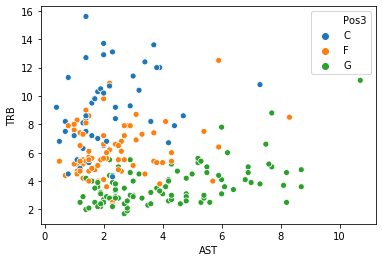

In [25]:
sns.scatterplot(data = nba_data, x = 'AST', y = 'TRB', hue = 'Pos3');

As you can see, when using just rebounds and assists as our features, we see pretty decent cluster separation. That is, Centers, Forwards, and Guards appear in different regions of the plot.

## One-vs-Rest Logistic Regression

We only discussed binary logistic regression in class, but there is a natural extension to binary logistic regression called one-vs-rest logistic regression for multiclass classification. This is discussed in the [extra slides in lecture 22](https://docs.google.com/presentation/d/18APMVrMwUYsL3F99P4vH1Ysxd-of-dPWhfN8gu7Hlg8/edit#slide=id.g70b8c9ba27_3_85). In essence, one-vs-rest logistic regression simply builds one binary logistic regression classifier for each of the $N$ classes (in this scenario $N = 3$). We then predict the class corresponding to the classifier that gives the highest probability among the $N$ classes.

Before using logistic regression, let's first split `nba_data` into a training set and test set.

In [26]:
nba_train, nba_test = train_test_split(nba_data, test_size=0.25, random_state=100)
nba_train = nba_train.sort_values(by='Pos')
nba_test = nba_test.sort_values(by='Pos')

### Question 2a

In the cell below, set `logistic_regression_model` to be a one-vs-rest logistic regression model. Then, fit that model using the `AST` and `TRB` columns (in that order) from `nba_train` as our features, and `Pos3` as our response variable.

Remember, [`sklearn.linear_model.LogisticRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) has already been imported for you. There is an optional parameter you need to specify in order to make your model a multi-class one-vs-rest classifier. See the documentation for more details.

<!--
BEGIN QUESTION
name: q2a
-->

In [27]:
logistic_regression_model = LogisticRegression(multi_class = 'ovr')
logistic_regression_model.fit(nba_train[['AST','TRB']], nba_train['Pos3'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [28]:
ok.grade("q2a");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



To see our classifier in action, we can use `logistic_regression_model.predict` and see what it outputs.

In [29]:
nba_train['Predicted (OVRLR) Pos3'] = logistic_regression_model.predict(nba_train[['AST', 'TRB']])
nba_train[['AST', 'TRB', 'Pos3', 'Predicted (OVRLR) Pos3']].head(15)

,AST,TRB,Pos3,Predicted (OVRLR) Pos3
655,1.4,8.6,C,C
644,2.0,10.2,C,C
703,0.8,4.5,C,F
652,1.6,7.2,C,C
165,1.4,7.5,C,C
122,2.4,8.4,C,C
353,7.3,10.8,C,C
367,1.4,8.6,C,C
408,1.2,4.9,C,F
161,3.9,12.0,C,C


Our model does decently well here, as you can see visually above. Below, we compute the training accuracy:

In [30]:
lr_training_accuracy = logistic_regression_model.score(nba_train[['AST', 'TRB']], nba_train['Pos3'])
lr_training_accuracy

0.7964071856287425

We can compute the test accuracy as well by looking at `nba_test` instead of `nba_train`:

In [31]:
lr_test_accuracy = logistic_regression_model.score(nba_test[['AST', 'TRB']], nba_test['Pos3'])
lr_test_accuracy

0.6607142857142857

Now, let's draw the decision boundary for this logistic regression classifier, and see how the classifier performs on both the training and test data.

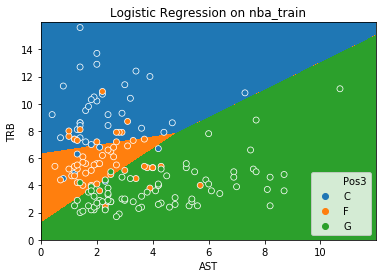

In [32]:
sns_cmap = ListedColormap(np.array(sns.color_palette())[0:3, :])

xx, yy = np.meshgrid(np.arange(0, 12, 0.02), np.arange(0, 16, 0.02))
Z_string = logistic_regression_model.predict(np.c_[xx.ravel(), yy.ravel()])
categories, Z_int = np.unique(Z_string, return_inverse = True)
Z_int = Z_int.reshape(xx.shape)
plt.contourf(xx, yy, Z_int, cmap = sns_cmap)
sns.scatterplot(data = nba_train, x = 'AST', y = 'TRB', hue = 'Pos3')
plt.title('Logistic Regression on nba_train');

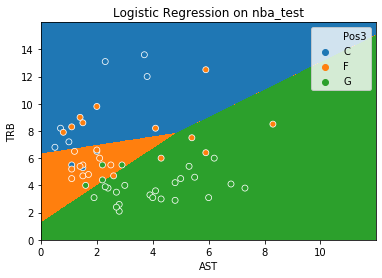

In [33]:
sns_cmap = ListedColormap(np.array(sns.color_palette())[0:3, :])

xx, yy = np.meshgrid(np.arange(0, 12, 0.02), np.arange(0, 16, 0.02))
Z_string = logistic_regression_model.predict(np.c_[xx.ravel(), yy.ravel()])
categories, Z_int = np.unique(Z_string, return_inverse = True)
Z_int = Z_int.reshape(xx.shape)
plt.contourf(xx, yy, Z_int, cmap = sns_cmap)
sns.scatterplot(data = nba_test, x = 'AST', y = 'TRB', hue = 'Pos3')
plt.title('Logistic Regression on nba_test');

Our one-vs-rest logistic regression was able to find a linear decision boundary between the three classes. It generally classifies centers as players with a lot of rebounds, forwards as players with a medium number of rebounds and a low number of assists, and guards as players with a low number of rebounds. 

Note: In practice we would use many more features – we only used 2 here just so that we could visualize the decision boundary.

## Decision Trees

### Question 2b

Let's now create a decision tree classifier on the same training data `nba_train`, and look at the resulting decision boundary. 

In the following cell, first, use [`tree.DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) to fit a model using the same features and response as above, and call this model `decision_tree_model`. Set the `random_state` parameter to 42.

**Hint:** Your code will be mostly be the same as question 2a.

<!--
BEGIN QUESTION
name: q2b
-->

In [34]:
decision_tree_model = tree.DecisionTreeClassifier()
decision_tree_model.fit(nba_train[['AST','TRB']], nba_train['Pos3'])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [35]:
ok.grade("q2b");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



Now, let's draw the decision boundary for this decision tree classifier, and see how the classifier performs on both the training and test data.

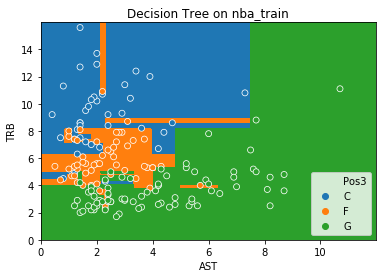

In [36]:
xx, yy = np.meshgrid(np.arange(0, 12, 0.02), np.arange(0, 16, 0.02))
Z_string = decision_tree_model.predict(np.c_[xx.ravel(), yy.ravel()])
categories, Z_int = np.unique(Z_string, return_inverse = True)
Z_int = Z_int.reshape(xx.shape)
plt.contourf(xx, yy, Z_int, cmap = sns_cmap)
sns.scatterplot(data = nba_train, x = 'AST', y = 'TRB', hue = 'Pos3')
plt.title('Decision Tree on nba_train');

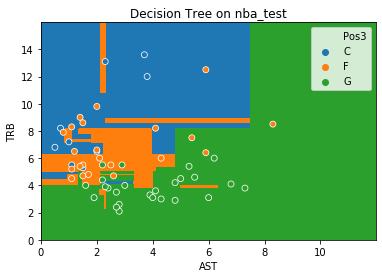

In [37]:
xx, yy = np.meshgrid(np.arange(0, 12, 0.02), np.arange(0, 16, 0.02))
Z_string = decision_tree_model.predict(np.c_[xx.ravel(), yy.ravel()])
categories, Z_int = np.unique(Z_string, return_inverse = True)
Z_int = Z_int.reshape(xx.shape)
plt.contourf(xx, yy, Z_int, cmap = sns_cmap)
sns.scatterplot(data = nba_test, x = 'AST', y = 'TRB', hue = 'Pos3')
plt.title('Decision Tree on nba_test');

### Question 2c

Set `dt_training_accuracy` to be the training accuracy of the decision tree model and `dt_test_accuracy` to be the test accuracy.

**Hint:** If you're failing this test, make sure you have the correct `random_state` parameter to `tree.DecisionTreeClassifier` in question 2b.

<!--
BEGIN QUESTION
name: q2c
-->

In [38]:
dt_training_accuracy = decision_tree_model.score(nba_train[['AST', 'TRB']], nba_train['Pos3'])
dt_test_accuracy = decision_tree_model.score(nba_test[['AST', 'TRB']], nba_test['Pos3'])
dt_training_accuracy, dt_test_accuracy

(0.9940119760479041, 0.6428571428571429)

In [39]:
ok.grade("q2c");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



## Random Forests

### Question 2d

Let's now create a random forest classifier on the same training data `nba_train` and look at the resulting decision boundary. 

In the following cell, use [`ensemble.RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) to fit a model using the same features and response as above, and call this model `random_forest_model`. Use 20 trees in your random forest classifier, and set the `random_state` parameter to 42.

**Hint:** Your code for both parts will be mostly the same as questions 2a and 2b.

**Hint:** Look at the `n_estimators` parameter of `ensemble.RandomForestClassifier`.

<!--
BEGIN QUESTION
name: q2d
-->

In [40]:
random_forest_model = ensemble.RandomForestClassifier(n_estimators = 20, random_state = 42)
random_forest_model.fit(nba_train[['AST','TRB']], nba_train['Pos3'])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [41]:
ok.grade("q2d");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



Now, let's draw the decision boundary for this random forest classifier, and see how the classifier performs on both the training and test data.

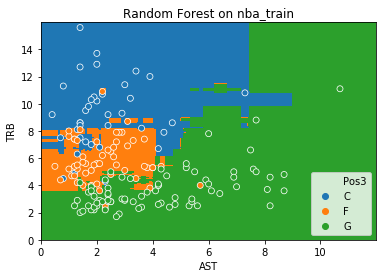

In [42]:
xx, yy = np.meshgrid(np.arange(0, 12, 0.02), np.arange(0, 16, 0.02))
Z_string = random_forest_model.predict(np.c_[xx.ravel(), yy.ravel()])
categories, Z_int = np.unique(Z_string, return_inverse = True)
Z_int = Z_int.reshape(xx.shape)
plt.contourf(xx, yy, Z_int, cmap = sns_cmap)
sns.scatterplot(data = nba_train, x = 'AST', y = 'TRB', hue = 'Pos3')
plt.title('Random Forest on nba_train');

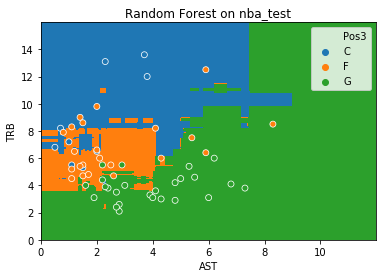

In [43]:
xx, yy = np.meshgrid(np.arange(0, 12, 0.02), np.arange(0, 16, 0.02))
Z_string = random_forest_model.predict(np.c_[xx.ravel(), yy.ravel()])
categories, Z_int = np.unique(Z_string, return_inverse = True)
Z_int = Z_int.reshape(xx.shape)
plt.contourf(xx, yy, Z_int, cmap = sns_cmap)
sns.scatterplot(data = nba_test, x = 'AST', y = 'TRB', hue = 'Pos3')
plt.title('Random Forest on nba_test');

### Question 2e

Set `rf_train_accuracy` to be the training accuracy of the random forest model and `rf_test_accuracy` to be the test accuracy.

**Hint:** If you're failing this test, make sure you have the correct parameters to `ensemble.RandomForestClassifier` in question 2d.

<!--
BEGIN QUESTION
name: q2e
-->

In [44]:
rf_train_accuracy = random_forest_model.score(nba_train[['AST', 'TRB']], nba_train['Pos3'])
rf_test_accuracy = random_forest_model.score(nba_test[['AST', 'TRB']], nba_test['Pos3'])
rf_train_accuracy, rf_test_accuracy

(0.9760479041916168, 0.7142857142857143)

In [45]:
ok.grade("q2e");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



### Question 2f

Looking at the three models you created (multiclass one-vs-rest logistic regression, decision tree, random forest), which model performed the best on the training set, and which model performed the best on the test set? How are the training and test accuracy related for the three models, and how do the decision boundaries generated for each of the three models relate to the model's performance?

<!--
BEGIN QUESTION
name: q2f
-->

The decision tree model performed the best on the training set, and the random forest performed the best on the test set. It is interesting to see the relation between the test and training accuracy between the three models, where the logistic ovr model sits in the middle with its training set accuracy being not too great, but it's test set accuracy being better then the normal decision tree's. This is because the decision tree seems to have heavily overfit the training data, with a very high training set accuracy but then resulting in the lowest test set accuracy. Thus, the Random Forest model fixes this overfitting found in decision trees very well and creates a model which has a better test set accuracy compared to the other two models, as well as a relatively high training set accuracy compared to the logistic model.

# Make sure to complete Vitamin 14 on Gradescope by 11:59 PM on Monday, 12/2!

# Submit
Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output.
**Please save before submitting!**

In [46]:
# Save your notebook first, then run this cell to submit.
ok.submit()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'lab14.ipynb'.
Submit... 100% complete
Submission successful for user: kpusztai@berkeley.edu
URL: https://okpy.org/cal/data100/fa19/lab14/submissions/GRr9yJ

